# CMA-ES Approach in finding Dwell Time Profiles from NETSEQ Data

## Problem

The NET-seq signal $S(x) = D(x) \cdot j(x)$, where $D(x)$ is the RNAP dwell time and $j(x)$ is the position-dependent flux. The TASEP simulation is a nonlinear forward model $F: D \to S$. We seek $D^*$ minimizing $\|F(D^*) - S_{\text{exp}}\|^2$.

## Why CMA-ES?

Richardson-Lucy iterative deconvolution fails because:
1. The forward model is nonlinear (exclusion, Rho termination feedback)
2. RL converges to a fixed point that is *worse* than the initial guess (see EXPLORATION.md)

CMA-ES (Covariance Matrix Adaptation Evolution Strategy) is a gradient-free evolutionary optimizer that:
- Does not require or approximate gradients
- Handles noisy fitness functions (rank-based selection, not value-based)
- Scales to ~1000D with sep-CMA-ES (diagonal covariance, O(n) complexity)
- Naturally explores the loss landscape without the self-defeating feedback that breaks RL

## Approach

- Optimize in log-space: $\theta(x) = \log D(x)$ to enforce $D(x) > 0$
- Use sep-CMA-ES (`CMA_diagonal=True`) for O(n) scaling to 1149 dimensions
- Initial guess: $D^0 = S_{\text{exp,norm}}$ (known near-optimal from RL analysis)
- Small $\sigma_0 = 0.1$ in log-space (~10% perturbation in D-space)
- Objective: $\text{MSE}(S_{\text{exp,norm}},\; S_{\text{sim,norm}}(D))$

In [12]:
try:
    import cma
    print(f"cma version: {cma.__version__}")
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cma"])
    import cma
    print(f"Installed cma version: {cma.__version__}")

import os
import time
import pickle
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from netseq_tasep_fast import (
    netseq_tasep_fast,
    _load_gene_parameters,
)

cma version: 4.4.2


## Configuration

In [13]:
# --- Gene and simulation parameters ---
GENE = "insQ"
N_RUNS = 200          # TASEP runs per objective evaluation (noise/speed tradeoff)
N_WORKERS = None      # None = os.cpu_count()

# --- CMA-ES parameters ---
SIGMA0 = 0.1         # Initial step size in log-space (~10% perturbation in D-space)
MAX_GENERATIONS = 500 # Maximum CMA-ES generations
POPSIZE = None        # None = pycma default (4 + floor(3*ln(n)) = 25 for n=1149)

# --- Logging/checkpointing ---
CHECKPOINT_EVERY = 25      # Save checkpoint every N generations
CHECKPOINT_DIR = Path("cmaes_checkpoints")
DISPLAY_EVERY = 1          # Print progress every N generations

# --- Reproducibility ---
CMA_SEED = 67              # CMA-ES internal RNG seed
SIM_BASE_SEED = 10_000     # Base seed for TASEP simulations (incremented per eval)

# --- Resume from checkpoint (set to path to resume, or None to start fresh) ---
RESUME_FROM = None          # e.g., "cmaes_checkpoints/gen_0100.pkl"

In [14]:
# --- Load gene data ---
base_params = _load_gene_parameters(GENE)
S_exp_norm = base_params["RNAP_dwellTimeProfile"].copy()  # Already normalized to mean=1
gene_length = len(S_exp_norm)

print(f"Gene: {GENE}")
print(f"Gene length: {gene_length} bp")
print(f"KRutLoading: {base_params['KRutLoading']}")
print(f"kRiboLoading: {base_params['kRiboLoading']:.4f}")

# Initial guess in log-space
D_init = S_exp_norm.copy()
theta_init = np.log(D_init)

print(f"\nlog(D_init) stats: mean={theta_init.mean():.4f}, std={theta_init.std():.4f}")
print(f"D_init stats: mean={D_init.mean():.4f}, min={D_init.min():.4f}, max={D_init.max():.4f}")

Gene: insQ
Gene length: 1149 bp
KRutLoading: 0.13
kRiboLoading: 0.0220

log(D_init) stats: mean=-0.7579, std=1.0240
D_init stats: mean=1.0000, min=0.1948, max=58.0638


## Objective Function (Batch Evaluation)

CMA-ES optimizes $\theta(x) = \log D(x)$. The objective:
1. Exponentiates: $D = \exp(\theta)$
2. Normalizes: $D_{\text{norm}} = D / \text{mean}(D)$
3. Runs TASEP forward model (averaged over `N_RUNS` stochastic realizations)
4. Normalizes output: $S_{\text{sim,norm}} = S_{\text{sim}} / \text{mean}(S_{\text{sim}})$
5. Returns: $\text{MSE} = \frac{1}{L}\sum_x (S_{\text{exp}}(x) - S_{\text{sim}}(x))^2$

**Batch evaluation**: Instead of evaluating candidates sequentially, we flatten all `popsize × N_RUNS` simulations into one parallel sweep. With 25 candidates × 200 runs = 5000 simulations per generation, this maximizes CPU utilization and eliminates thread pool overhead.

In [15]:
def run_single_simulation(args):
    """Worker function for a single TASEP simulation. Returns (candidate_idx, NETseq_sum)."""
    candidate_idx, dwell_profile, seed, base_params_dict = args
    params = dict(base_params_dict)
    params["RNAP_dwellTimeProfile"] = dwell_profile
    result = netseq_tasep_fast(params, seed=seed)
    return candidate_idx, np.asarray(result["NETseq_sum"], dtype=float)


def run_simulations_with_dwell(dwell_profile, base_params, n_runs, base_seed, n_workers=None):
    """Run n_runs TASEP simulations with a custom dwell profile and return mean NETseq_sum.
    (Retained for baseline evaluation and high-fidelity runs.)
    """
    if n_workers is None:
        n_workers = os.cpu_count() or 1

    args_list = [(0, dwell_profile, base_seed + i, base_params) for i in range(n_runs)]
    
    if n_workers <= 1:
        outputs = [run_single_simulation(a)[1] for a in args_list]
    else:
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
            results = list(executor.map(run_single_simulation, args_list))
        outputs = [r[1] for r in results]

    netseq_total = np.zeros_like(outputs[0], dtype=float)
    for output in outputs:
        netseq_total += output
    return netseq_total / float(n_runs)


# Global evaluation counter for deterministic seed management
_eval_counter = 0

def objective_batch(thetas, base_seed):
    """
    Batch objective: evaluate multiple candidates in one parallel sweep.
    
    Args:
        thetas: list of candidate theta vectors (log-space dwell profiles)
        base_seed: starting seed for this batch of evaluations
    
    Returns:
        List of MSE values, one per candidate
    """
    n_candidates = len(thetas)
    n_workers = N_WORKERS if N_WORKERS is not None else (os.cpu_count() or 1)
    
    # Convert all thetas to normalized dwell profiles
    D_norms = []
    for theta in thetas:
        D = np.exp(theta)
        D_norms.append(D / np.mean(D))
    
    # Build all (candidate_idx, dwell_profile, seed) combinations
    # Total simulations: n_candidates * N_RUNS
    args_list = []
    for cand_idx, D_norm in enumerate(D_norms):
        for run_idx in range(N_RUNS):
            seed = base_seed + cand_idx * N_RUNS + run_idx
            args_list.append((cand_idx, D_norm, seed, base_params))
    
    # Run all simulations in one parallel sweep
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(executor.map(run_single_simulation, args_list))
    
    # Aggregate results per candidate
    # results is a list of (candidate_idx, NETseq_sum) tuples
    accumulators = [np.zeros(gene_length, dtype=float) for _ in range(n_candidates)]
    counts = [0] * n_candidates
    
    for cand_idx, netseq_sum in results:
        accumulators[cand_idx] += netseq_sum
        counts[cand_idx] += 1
    
    # Compute MSE for each candidate
    fitnesses = []
    for cand_idx in range(n_candidates):
        S_sim = accumulators[cand_idx] / counts[cand_idx]
        S_sim_mean = np.mean(S_sim)
        if S_sim_mean > 0:
            S_sim_norm = S_sim / S_sim_mean
            mse = np.mean((S_exp_norm - S_sim_norm) ** 2)
        else:
            mse = 1e6  # Degenerate: no RNAPs survived
        fitnesses.append(mse)
    
    return fitnesses


def objective(theta):
    """Single-candidate objective (for baseline evaluation)."""
    global _eval_counter
    _eval_counter += 1

    D = np.exp(theta)
    D_norm = D / np.mean(D)

    eval_seed = SIM_BASE_SEED + _eval_counter * N_RUNS
    S_sim = run_simulations_with_dwell(D_norm, base_params, N_RUNS, eval_seed, N_WORKERS)

    S_sim_mean = np.mean(S_sim)
    if S_sim_mean > 0:
        S_sim_norm = S_sim / S_sim_mean
    else:
        return 1e6

    return np.mean((S_exp_norm - S_sim_norm) ** 2)

## Baseline Evaluation

Evaluate the initial guess $D^0 = S_{\text{exp,norm}}$ to establish starting fitness. This should match the RL iter-0 residual from `iterative_deconvolution.ipynb` (~3.48 RMS).

In [17]:
import platform

# CPU info
cpu_info = platform.processor() or "Unknown"
try:
    with open("/proc/cpuinfo", "r") as f:
        for line in f:
            if line.startswith("model name"):
                cpu_info = line.split(":")[1].strip()
                break
except Exception:
    pass

print(f"CPU: {cpu_info}")
print(f"CPU cores: {os.cpu_count()}")

# Baseline evaluation (single candidate)
t0 = time.time()
baseline_mse = objective(theta_init)
t_baseline = time.time() - t0
baseline_rms = np.sqrt(baseline_mse)

print(f"\nBaseline MSE (D=S_exp_norm): {baseline_mse:.6f}")
print(f"Baseline RMS residual:       {baseline_rms:.4f}")
print(f"Single evaluation time:      {t_baseline:.2f}s")

# Benchmark batch evaluation (simulating one generation)
popsize_est = POPSIZE or (4 + int(3 * np.log(gene_length)))
print(f"\n--- Batch evaluation benchmark (population={popsize_est}) ---")

# Create dummy population (theta_init repeated)
dummy_pop = [theta_init + np.random.randn(gene_length) * 0.01 for _ in range(popsize_est)]

t0 = time.time()
_ = objective_batch(dummy_pop, SIM_BASE_SEED + 100000)
t_batch = time.time() - t0

# Compare with sequential estimate
t_sequential_est = t_baseline * popsize_est

print(f"Batch time ({popsize_est} candidates, {popsize_est * N_RUNS} sims): {t_batch:.2f}s")
print(f"Sequential estimate ({popsize_est} × {t_baseline:.2f}s):            {t_sequential_est:.2f}s")
print(f"Speedup: {t_sequential_est / t_batch:.1f}x")

print(f"\nEstimated time per generation: ~{t_batch:.1f}s")
print(f"Estimated total for {MAX_GENERATIONS} generations: ~{t_batch * MAX_GENERATIONS / 3600:.2f} hours")

CPU: AMD Ryzen Threadripper PRO 3955WX 16-Cores
CPU cores: 32

Baseline MSE (D=S_exp_norm): 12.327057
Baseline RMS residual:       3.5110
Single evaluation time:      0.19s

--- Batch evaluation benchmark (population=25) ---
Batch time (25 candidates, 5000 sims): 4.47s
Sequential estimate (25 × 0.19s):            4.83s
Speedup: 1.1x

Estimated time per generation: ~4.5s
Estimated total for 500 generations: ~0.62 hours


## CMA-ES Optimization

Using sep-CMA-ES (`CMA_diagonal=True`) for O(n) time and space complexity. At n=1149, full CMA-ES would require an O($n^3$) eigendecomposition per generation. Sep-CMA-ES stores only the diagonal and runs in O(n).

In [18]:
# Create checkpoint directory
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# CMA-ES options
opts = {
    'CMA_diagonal': True,       # sep-CMA-ES: diagonal covariance, O(n)
    'seed': CMA_SEED,
    'maxiter': MAX_GENERATIONS,
    'verb_disp': 0,             # Suppress pycma's own printing
    'verb_log': 0,              # Disable pycma file logging (we do our own)
    'tolfun': 1e-8,             # Very tight: let it run until maxiter
    'tolx': 1e-8,               # Very tight: let it run until maxiter
}
if POPSIZE is not None:
    opts['popsize'] = POPSIZE

# Initialize or resume
if RESUME_FROM is not None:
    with open(RESUME_FROM, 'rb') as f:
        checkpoint = pickle.load(f)
    es = checkpoint['es']
    history = checkpoint['history']
    _eval_counter = checkpoint.get('eval_counter', 0)
    # For backwards compatibility with old checkpoints
    _resume_batch_seed = checkpoint.get('batch_seed', SIM_BASE_SEED + len(history['gen']) * es.popsize * N_RUNS)
    print(f"Resumed from {RESUME_FROM}, generation {len(history['gen'])}")
else:
    es = cma.CMAEvolutionStrategy(theta_init, SIGMA0, opts)
    history = {
        'gen': [],
        'f_best': [],
        'f_median': [],
        'sigma': [],
        'elapsed': [],
        'theta_best': None,
    }
    _eval_counter = 0
    _resume_batch_seed = None
    print(f"Starting fresh CMA-ES optimization")

print(f"  Dimension: {es.N}")
print(f"  Population size: {es.popsize}")
print(f"  sigma0: {SIGMA0}")
print(f"  n_runs per eval: {N_RUNS}")
print(f"  Total sims per generation: {es.popsize * N_RUNS:,}")

Starting fresh CMA-ES optimization
  Dimension: 1149
  Population size: 25
  sigma0: 0.1
  n_runs per eval: 200
  Total sims per generation: 5,000


In [19]:
t_start = time.time()
gen_count = len(history['gen'])

# Use resumed seed if available, otherwise start fresh
batch_seed = _resume_batch_seed if (_resume_batch_seed is not None) else SIM_BASE_SEED

try:
    while not es.stop():
        # Sample population
        candidates = es.ask()

        # Batch evaluate all candidates in one parallel sweep
        fitnesses = objective_batch(candidates, batch_seed)
        batch_seed += len(candidates) * N_RUNS  # Advance seed for next generation

        # Update distribution
        es.tell(candidates, fitnesses)

        gen_count += 1
        elapsed = time.time() - t_start

        # Log
        f_best = es.result.fbest
        f_median = np.median(fitnesses)
        sigma = es.sigma

        history['gen'].append(gen_count)
        history['f_best'].append(f_best)
        history['f_median'].append(f_median)
        history['sigma'].append(sigma)
        history['elapsed'].append(elapsed)
        history['theta_best'] = es.result.xbest.copy()

        if gen_count % DISPLAY_EVERY == 0:
            eta = elapsed / gen_count * (MAX_GENERATIONS - gen_count)
            print(f"  gen {gen_count:4d} | f_best={f_best:.6f} | f_med={f_median:.6f} | "
                  f"sigma={sigma:.4f} | {elapsed:.0f}s | ETA {eta:.0f}s")

        # Checkpoint
        if gen_count % CHECKPOINT_EVERY == 0:
            ckpt_path = CHECKPOINT_DIR / f"gen_{gen_count:04d}.pkl"
            with open(ckpt_path, 'wb') as f:
                pickle.dump({
                    'es': es,
                    'history': history,
                    'eval_counter': _eval_counter,
                    'batch_seed': batch_seed,
                }, f)
            print(f"  >> Checkpoint saved: {ckpt_path}")

except KeyboardInterrupt:
    print(f"\n  Interrupted at generation {gen_count}. Saving checkpoint...")
    ckpt_path = CHECKPOINT_DIR / f"gen_{gen_count:04d}_interrupted.pkl"
    with open(ckpt_path, 'wb') as f:
        pickle.dump({
            'es': es,
            'history': history,
            'eval_counter': _eval_counter,
            'batch_seed': batch_seed,
        }, f)
    print(f"  >> Checkpoint saved: {ckpt_path}")

total_time = time.time() - t_start
stop_conditions = es.stop()
print(f"\nDone in {total_time:.1f}s ({gen_count} generations)")
print(f"Stop conditions: {stop_conditions}")
print(f"Best MSE: {es.result.fbest:.6f} (RMS: {np.sqrt(es.result.fbest):.4f})")
print(f"Baseline MSE was: {baseline_mse:.6f} (RMS: {baseline_rms:.4f})")
print(f"Total simulations: {gen_count * es.popsize * N_RUNS:,}")

  gen    1 | f_best=11.844647 | f_med=12.274581 | sigma=0.0986 | 5s | ETA 2276s
  gen    2 | f_best=11.511111 | f_med=12.311342 | sigma=0.0967 | 9s | ETA 2271s
  gen    3 | f_best=11.079269 | f_med=11.985426 | sigma=0.0950 | 14s | ETA 2279s
  gen    4 | f_best=10.747383 | f_med=11.876301 | sigma=0.0955 | 18s | ETA 2258s
  gen    5 | f_best=10.523577 | f_med=11.670230 | sigma=0.0978 | 23s | ETA 2250s
  gen    6 | f_best=10.408494 | f_med=11.194143 | sigma=0.1014 | 27s | ETA 2241s
  gen    7 | f_best=10.187474 | f_med=10.861454 | sigma=0.1059 | 32s | ETA 2230s
  gen    8 | f_best=10.187474 | f_med=10.738570 | sigma=0.1114 | 36s | ETA 2224s
  gen    9 | f_best=10.056644 | f_med=10.564401 | sigma=0.1176 | 41s | ETA 2223s
  gen   10 | f_best=10.056644 | f_med=10.537637 | sigma=0.1242 | 45s | ETA 2218s
  gen   11 | f_best=10.056644 | f_med=10.537192 | sigma=0.1280 | 50s | ETA 2214s
  gen   12 | f_best=9.813557 | f_med=10.381344 | sigma=0.1328 | 54s | ETA 2208s
  gen   13 | f_best=9.813557 | 

/home/racda/Downloads/netseq-tasep/lib/python3.12/site-packages/cma/transformations.py:814: UserWarning: elements of z2[k] are larger than 55: [(k, idx, values)]=[(np.int64(0), [np.int64(942)], array([57.43068874]))]
  _warnings.warn("elements of z2[k] are larger than 55: "


  gen   84 | f_best=4.410009 | f_med=6.112857 | sigma=0.3413 | 379s | ETA 1877s


/home/racda/Downloads/netseq-tasep/lib/python3.12/site-packages/cma/transformations.py:814: UserWarning: elements of z2[k] are larger than 55: [(k, idx, values)]=[(np.int64(0), [np.int64(942)], array([62.91192065]))]
  _warnings.warn("elements of z2[k] are larger than 55: "


  gen   85 | f_best=4.293729 | f_med=5.418127 | sigma=0.3548 | 384s | ETA 1872s


/home/racda/Downloads/netseq-tasep/lib/python3.12/site-packages/cma/transformations.py:814: UserWarning: elements of z2[k] are larger than 55: [(k, idx, values)]=[(np.int64(0), [np.int64(942)], array([68.45583192]))]
  _warnings.warn("elements of z2[k] are larger than 55: "


  gen   86 | f_best=4.293729 | f_med=4.724037 | sigma=0.3700 | 388s | ETA 1868s


/home/racda/Downloads/netseq-tasep/lib/python3.12/site-packages/cma/transformations.py:814: UserWarning: elements of z2[k] are larger than 55: [(k, idx, values)]=[(np.int64(0), [np.int64(942)], array([63.35474765]))]
  _warnings.warn("elements of z2[k] are larger than 55: "


  gen   87 | f_best=4.196878 | f_med=5.043326 | sigma=0.3784 | 393s | ETA 1863s


/home/racda/Downloads/netseq-tasep/lib/python3.12/site-packages/cma/transformations.py:814: UserWarning: elements of z2[k] are larger than 55: [(k, idx, values)]=[(np.int64(0), [np.int64(942)], array([61.49752441]))]
  _warnings.warn("elements of z2[k] are larger than 55: "


  gen   88 | f_best=4.196878 | f_med=4.772789 | sigma=0.3782 | 397s | ETA 1859s


/home/racda/Downloads/netseq-tasep/lib/python3.12/site-packages/cma/transformations.py:814: UserWarning: elements of z2[k] are larger than 55: [(k, idx, values)]=[(np.int64(0), [np.int64(942)], array([56.48375972]))]
  _warnings.warn("elements of z2[k] are larger than 55: "


  gen   89 | f_best=4.077675 | f_med=4.708859 | sigma=0.3765 | 401s | ETA 1854s
  gen   90 | f_best=4.077675 | f_med=4.897623 | sigma=0.3769 | 406s | ETA 1850s
  gen   91 | f_best=4.077675 | f_med=4.721556 | sigma=0.3705 | 411s | ETA 1845s
  gen   92 | f_best=4.077675 | f_med=4.740928 | sigma=0.3675 | 415s | ETA 1840s
  gen   93 | f_best=3.997674 | f_med=4.700731 | sigma=0.3610 | 419s | ETA 1835s
  gen   94 | f_best=3.997674 | f_med=4.754028 | sigma=0.3579 | 424s | ETA 1831s
  gen   95 | f_best=3.997674 | f_med=4.868061 | sigma=0.3519 | 428s | ETA 1826s
  gen   96 | f_best=3.983150 | f_med=4.487462 | sigma=0.3507 | 433s | ETA 1822s
  gen   97 | f_best=3.849535 | f_med=4.448072 | sigma=0.3519 | 437s | ETA 1817s
  gen   98 | f_best=3.821095 | f_med=4.753473 | sigma=0.3548 | 442s | ETA 1812s
  gen   99 | f_best=3.821095 | f_med=4.523683 | sigma=0.3515 | 446s | ETA 1808s
  gen  100 | f_best=3.821095 | f_med=4.571806 | sigma=0.3443 | 451s | ETA 1803s
  >> Checkpoint saved: cmaes_checkpoints

In [20]:
# Save final state
final_path = CHECKPOINT_DIR / "final.pkl"
with open(final_path, 'wb') as f:
    pickle.dump({
        'es': es,
        'history': history,
        'eval_counter': _eval_counter,
        'D_best': np.exp(es.result.xbest) / np.mean(np.exp(es.result.xbest)),
        'S_exp_norm': S_exp_norm,
        'gene': GENE,
    }, f)
print(f"Final state saved to {final_path}")

Final state saved to cmaes_checkpoints/final.pkl


## Convergence Analysis

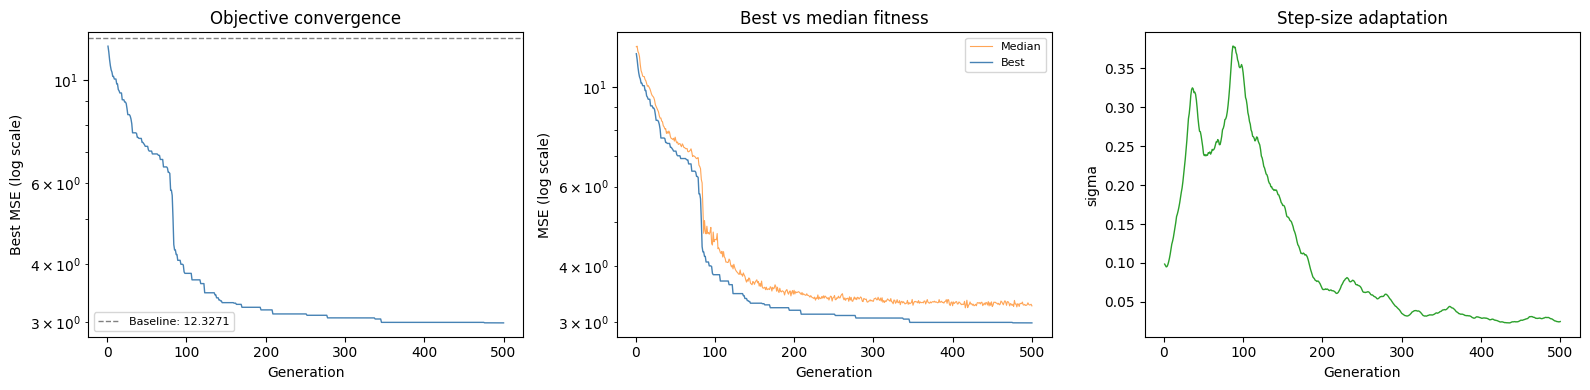

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

gens = np.array(history['gen'])

# Best objective
axes[0].semilogy(gens, history['f_best'], '-', color='steelblue', lw=1)
axes[0].axhline(baseline_mse, color='gray', ls='--', lw=1, label=f'Baseline: {baseline_mse:.4f}')
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Best MSE (log scale)')
axes[0].set_title('Objective convergence')
axes[0].legend(fontsize=8)

# Best vs median
axes[1].semilogy(gens, history['f_median'], '-', color='tab:orange', lw=0.8, alpha=0.7, label='Median')
axes[1].semilogy(gens, history['f_best'], '-', color='steelblue', lw=1, label='Best')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('MSE (log scale)')
axes[1].set_title('Best vs median fitness')
axes[1].legend(fontsize=8)

# Sigma
axes[2].plot(gens, history['sigma'], '-', color='tab:green', lw=1)
axes[2].set_xlabel('Generation')
axes[2].set_ylabel('sigma')
axes[2].set_title('Step-size adaptation')

plt.tight_layout()
plt.show()

## Results: High-Fidelity Evaluation

Re-evaluate the best $D^*$ and the baseline with 300 runs for a clean comparison.

In [22]:
# Extract best D*
theta_best = es.result.xbest
D_best = np.exp(theta_best)
D_best_norm = D_best / np.mean(D_best)

# High-fidelity evaluation (300 runs)
print("Running high-fidelity evaluation of D* (300 runs)...")
t0 = time.time()
S_sim_best = run_simulations_with_dwell(D_best_norm, base_params, 300, 99999, N_WORKERS)
S_sim_best_norm = S_sim_best / np.mean(S_sim_best)
print(f"  Done in {time.time() - t0:.1f}s")

print("Running high-fidelity baseline (300 runs)...")
t0 = time.time()
S_sim_baseline = run_simulations_with_dwell(S_exp_norm, base_params, 300, 88888, N_WORKERS)
S_sim_baseline_norm = S_sim_baseline / np.mean(S_sim_baseline)
print(f"  Done in {time.time() - t0:.1f}s")

mse_best = np.mean((S_exp_norm - S_sim_best_norm) ** 2)
mse_baseline = np.mean((S_exp_norm - S_sim_baseline_norm) ** 2)

print(f"\nHigh-fidelity MSE comparison:")
print(f"  Baseline (D=S_exp):  MSE={mse_baseline:.6f}, RMS={np.sqrt(mse_baseline):.4f}")
print(f"  CMA-ES optimized D*: MSE={mse_best:.6f}, RMS={np.sqrt(mse_best):.4f}")
if mse_baseline > 0:
    print(f"  Improvement: {(1 - mse_best / mse_baseline) * 100:.1f}%")

Running high-fidelity evaluation of D* (300 runs)...
  Done in 0.3s
Running high-fidelity baseline (300 runs)...
  Done in 0.3s

High-fidelity MSE comparison:
  Baseline (D=S_exp):  MSE=11.924260, RMS=3.4532
  CMA-ES optimized D*: MSE=3.157648, RMS=1.7770
  Improvement: 73.5%


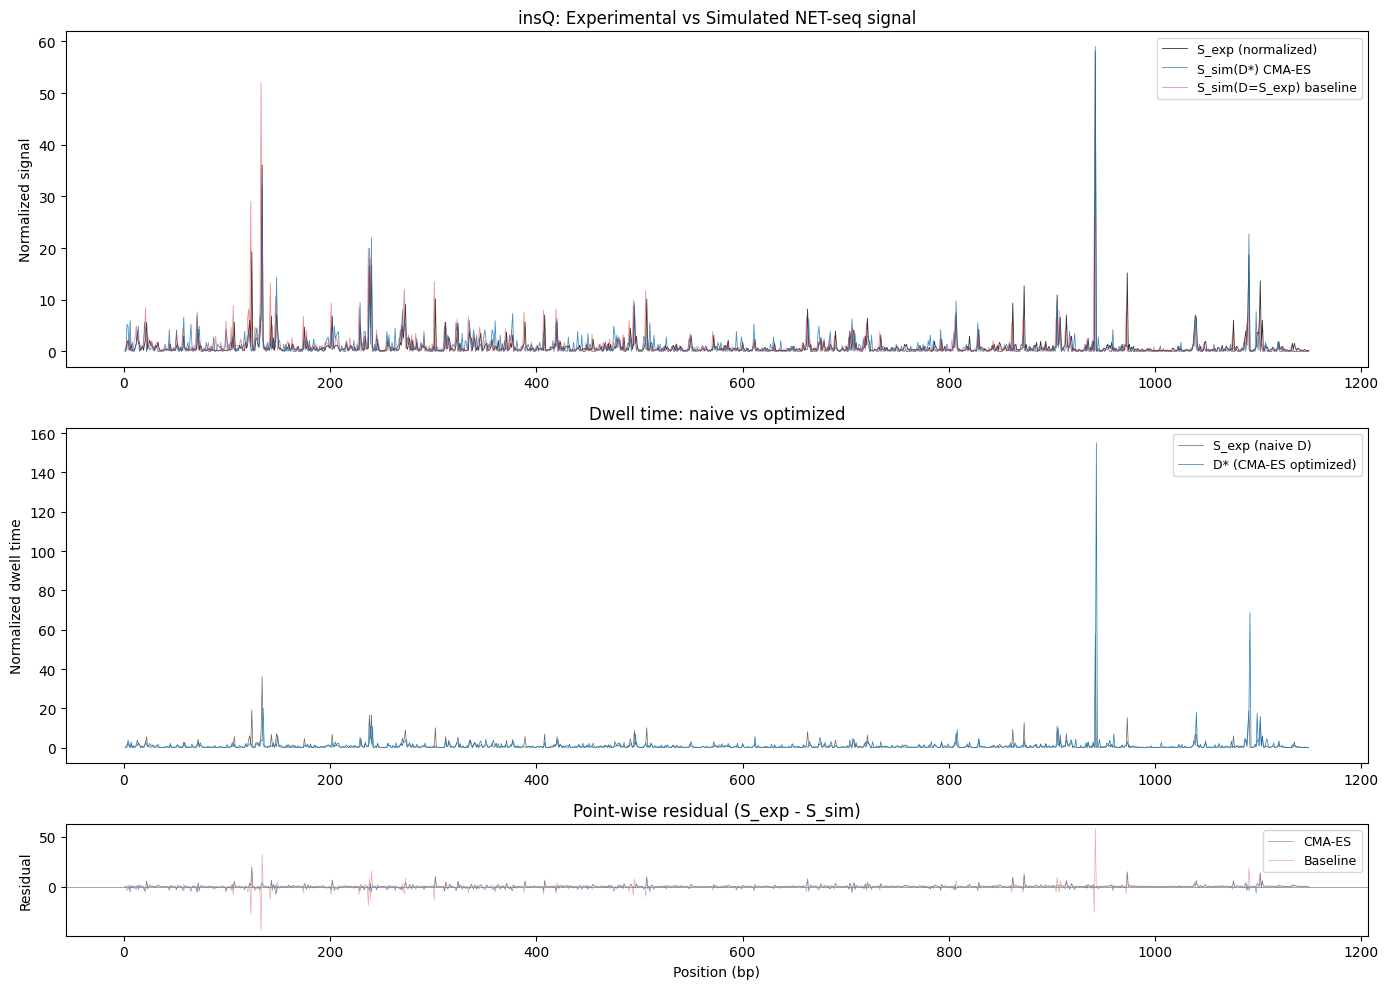

In [23]:
pos = np.arange(1, gene_length + 1)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 3, 1]})

# S_exp vs S_sim(D*) vs S_sim(baseline)
axes[0].plot(pos, S_exp_norm, lw=0.6, color='black', label='S_exp (normalized)', alpha=0.8)
axes[0].plot(pos, S_sim_best_norm, lw=0.6, color='tab:blue', label='S_sim(D*) CMA-ES', alpha=0.8)
axes[0].plot(pos, S_sim_baseline_norm, lw=0.6, color='tab:red', label='S_sim(D=S_exp) baseline', alpha=0.5)
axes[0].set_ylabel('Normalized signal')
axes[0].set_title(f'{GENE}: Experimental vs Simulated NET-seq signal')
axes[0].legend(fontsize=9)

# D* vs S_exp
axes[1].plot(pos, S_exp_norm, lw=0.5, color='black', label='S_exp (naive D)', alpha=0.6)
axes[1].plot(pos, D_best_norm, lw=0.5, color='tab:blue', label='D* (CMA-ES optimized)')
axes[1].set_ylabel('Normalized dwell time')
axes[1].set_title('Dwell time: naive vs optimized')
axes[1].legend(fontsize=9)

# Point-wise residual
axes[2].plot(pos, S_exp_norm - S_sim_best_norm, lw=0.5, color='tab:blue', alpha=0.7, label='CMA-ES')
axes[2].plot(pos, S_exp_norm - S_sim_baseline_norm, lw=0.5, color='tab:red', alpha=0.4, label='Baseline')
axes[2].axhline(0, color='gray', ls='-', lw=0.5)
axes[2].set_xlabel('Position (bp)')
axes[2].set_ylabel('Residual')
axes[2].set_title('Point-wise residual (S_exp - S_sim)')
axes[2].legend(fontsize=9)

plt.tight_layout()
plt.show()

## Implied Flux Profile

If $S(x) = D(x) \cdot j(x)$ and we have $D^*$, then the implied flux is $j^*(x) = S_{\text{sim}}^*(x) / D^*(x)$.

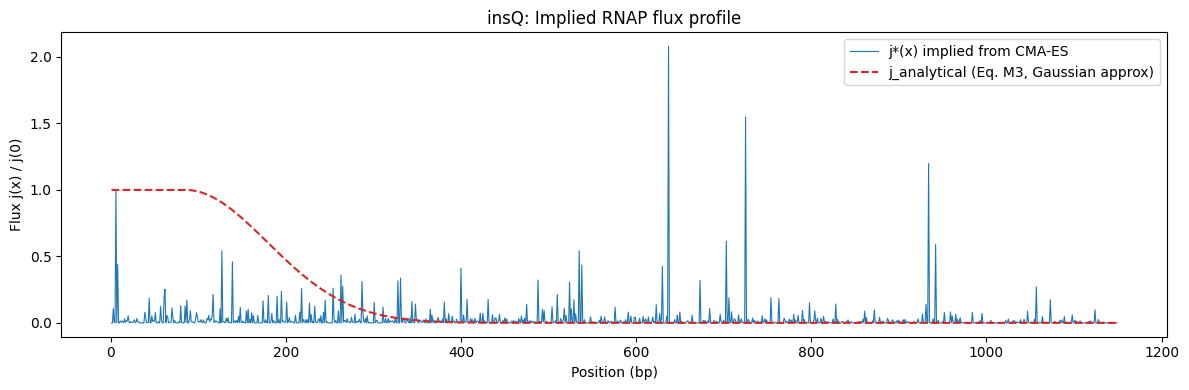

In [24]:
# Implied flux
j_implied = S_sim_best / np.maximum(D_best_norm, 1e-6)
j_implied_norm = j_implied / np.max(j_implied[:100])  # Normalize to ~1 at 5' end

# Analytical flux shape for comparison (Eq. M3)
ell_0 = 35 + 50  # ell_RNAP + ell_min = 85 bp
x = np.arange(1, gene_length + 1, dtype=float)
j_analytical = np.ones(gene_length)
mask = x > ell_0
j_analytical[mask] = np.exp(-base_params['KRutLoading'] / (2 * gene_length) * (x[mask] - ell_0) ** 2)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(pos, j_implied_norm, lw=0.8, color='tab:blue', label='j*(x) implied from CMA-ES')
ax.plot(pos, j_analytical, lw=1.5, color='tab:red', ls='--', label='j_analytical (Eq. M3, Gaussian approx)')
ax.set_xlabel('Position (bp)')
ax.set_ylabel('Flux j(x) / j(0)')
ax.set_title(f'{GENE}: Implied RNAP flux profile')
ax.legend()
plt.tight_layout()
plt.show()

## Correction Factor: D* / S_exp

The ratio $D^*(x) / S_{\text{exp}}(x)$ reveals the systematic correction CMA-ES applied. Under constant flux this ratio would be 1 everywhere. Deviations reveal flux contamination in the naive estimate.

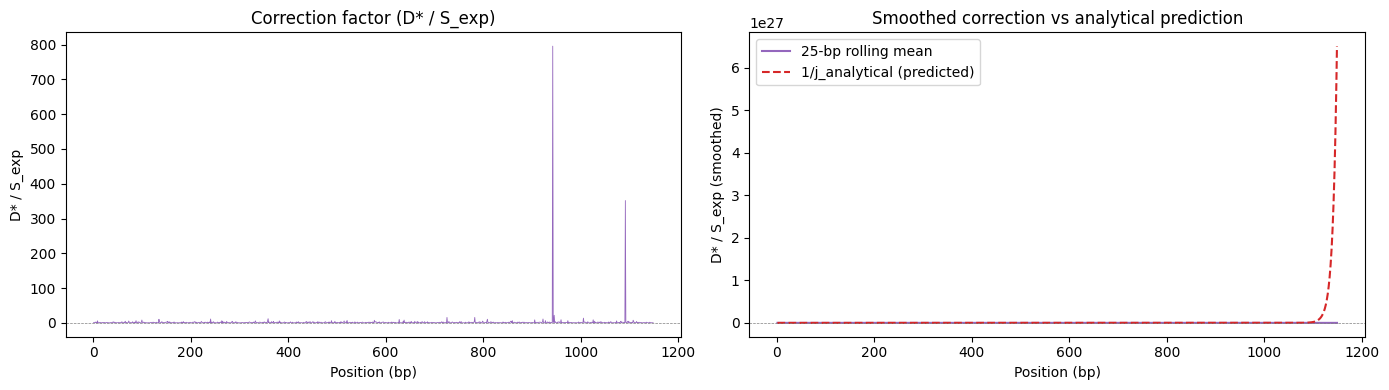

In [25]:
correction = D_best_norm / np.maximum(S_exp_norm, 1e-6)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(pos, correction, lw=0.6, color='tab:purple')
axes[0].axhline(1.0, color='gray', ls='--', lw=0.5)
axes[0].set_xlabel('Position (bp)')
axes[0].set_ylabel('D* / S_exp')
axes[0].set_title('Correction factor (D* / S_exp)')

# Smoothed version
window = 25
correction_smooth = np.convolve(correction, np.ones(window) / window, mode='same')
axes[1].plot(pos, correction_smooth, lw=1.5, color='tab:purple', label=f'{window}-bp rolling mean')
axes[1].plot(pos, 1.0 / j_analytical, lw=1.5, color='tab:red', ls='--', label='1/j_analytical (predicted)')
axes[1].axhline(1.0, color='gray', ls='--', lw=0.5)
axes[1].set_xlabel('Position (bp)')
axes[1].set_ylabel('D* / S_exp (smoothed)')
axes[1].set_title('Smoothed correction vs analytical prediction')
axes[1].legend()

plt.tight_layout()
plt.show()